In [40]:
import numpy as np
import pandas as pd

from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt

In [41]:
# Load (equivalente a fread(here(...)) )
dt = pd.read_csv("data/data_pubinv_final.csv")

# Pulizia anno 
dt["year"] = dt["year"].astype(str).str.strip()
dt["year_int"] = dt["year"].astype(int)

# Filtro 2000-2023
dt = dt[(dt["year_int"] >= 2000) & (dt["year_int"] <= 2023)].copy()
dt.Country.sort_values().unique()

array(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg',
       'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania',
       'Slovakia', 'Slovenia', 'Spain', 'Sweden'], dtype=object)

In [42]:
import pandas as pd

path = "data/WGI_CSV/WGICSV.csv"
wgi = pd.read_csv(path)

EU27 = [
    "Austria","Belgium","Bulgaria","Croatia","Cyprus","Czechia","Denmark","Estonia",
    "Finland","France","Germany","Greece","Hungary","Ireland","Italy","Latvia",
    "Lithuania","Luxembourg","Malta","Netherlands","Poland","Portugal","Romania",
    "Slovak Republic","Slovenia","Spain","Sweden"
]

KEEP_CODES = ["CC.EST", "GE.EST", "PV.EST", "RL.EST", "RQ.EST", "VA.EST"]

#filtro solo i 27 paesi EU
wgi_eu = wgi[
    wgi["Country Name"].isin(EU27) &
    wgi["Indicator Code"].isin(KEEP_CODES)
].copy()

print("wgi_eu shape:", wgi_eu.shape)
print(wgi_eu[["Country Name","Indicator Code","Indicator Name"]].drop_duplicates().head(20))

wgi_eu.to_csv("data/WGI_CSV/WGI_EU27_filtered_wide.csv", index=False)


# filtro anni dal 2000 al 2023
year_cols = [str(y) for y in range(2000, 2024) if str(y) in wgi_eu.columns]

#Wide -> Long (metto gli anni sulle righe)
wgi_eu_long = wgi_eu.melt(
    id_vars=["Country Name","Country Code","Indicator Name","Indicator Code"],
    value_vars=year_cols,
    var_name="year_int",
    value_name="value"
)
wgi_eu_long["year_int"] = wgi_eu_long["year_int"].astype(int)

wgi_eu_long.to_csv("data/WGI_CSV/WGI_EU27_filtered_long_2000_2023.csv", index=False)

# Panel
wgi_eu_long["ind"] = wgi_eu_long["Indicator Code"].str.replace(".", "_", regex=False)

wgi_panel = (
    wgi_eu_long
    .pivot_table(
        index=["Country Name", "Country Code", "year_int"],
        columns="ind",
        values="value",
        aggfunc="first"
    )
    .reset_index()
)
wgi_panel.columns.name = None

# ordinamento
wgi_panel = wgi_panel.sort_values(["Country Name", "year_int"]).reset_index(drop=True)

wgi_panel.to_csv("data/WGI_CSV/WGI_EU27_panel_sorted_2000_2023.csv", index=False)

print("Saved:")
print(" - data/WGI_CSV/WGI_EU27_filtered_wide.csv")
print(" - data/WGI_CSV/WGI_EU27_filtered_long_2000_2023.csv")
print(" - data/WGI_CSV/WGI_EU27_panel_sorted_2000_2023.csv")
print("Years kept:", sorted(wgi_panel["year_int"].unique())[:5], "...", sorted(wgi_panel["year_int"].unique())[-5:])


wgi_eu shape: (162, 29)
     Country Name Indicator Code  \
432       Austria         CC.EST   
438       Austria         GE.EST   
444       Austria         PV.EST   
450       Austria         RQ.EST   
456       Austria         RL.EST   
462       Austria         VA.EST   
684       Belgium         CC.EST   
690       Belgium         GE.EST   
696       Belgium         PV.EST   
702       Belgium         RQ.EST   
708       Belgium         RL.EST   
714       Belgium         VA.EST   
1044     Bulgaria         CC.EST   
1050     Bulgaria         GE.EST   
1056     Bulgaria         PV.EST   
1062     Bulgaria         RQ.EST   
1068     Bulgaria         RL.EST   
1074     Bulgaria         VA.EST   
1728      Croatia         CC.EST   
1734      Croatia         GE.EST   

                                         Indicator Name  
432                     Control of Corruption: Estimate  
438                  Government Effectiveness: Estimate  
444   Political Stability and Absence of Viol

In [43]:
import pandas as pd

# --- input ---
pub_path = "data/data_pubinv_final.csv"
wgi_path = "data/WGI_CSV/WGI_EU27_panel_sorted_2000_2023.csv" 

pub = pd.read_csv(pub_path)
wgi = pd.read_csv(wgi_path)

#uniformo anno
if "year" in pub.columns and "year_int" not in pub.columns:
    pub = pub.rename(columns={"year": "year_int"})
pub["year_int"] = pub["year_int"].astype(int)

wgi["year_int"] = wgi["year_int"].astype(int)

#uniformo codice paese
wgi = wgi.rename(columns={"Country Code": "ccode"})

pub["ccode"] = pub["ccode"].astype(str).str.strip()
wgi["ccode"] = wgi["ccode"].astype(str).str.strip()

WGI_COLS = ["CC_EST", "GE_EST", "PV_EST", "RL_EST", "RQ_EST", "VA_EST"]
wgi_small = wgi[["ccode", "year_int"] + WGI_COLS].copy()

#merge
pub_merged = pub.merge(wgi, on=["ccode", "year_int"], how="left")

#quante righe vuot?
missing_wgi = pub_merged["CC_EST"].isna().sum()
print("Righe senza match WGI (CC_EST NaN):", missing_wgi)




Righe senza match WGI (CC_EST NaN): 27


In [44]:
for col in WGI_COLS:
    pub_merged[col] = pub_merged[col].fillna(
        pub_merged.groupby("ccode")[col].transform("mean")
    )

out_path = "data/data_pubinv_final_with_WGI.csv"
pub_merged.to_csv(out_path, index=False)
print("Saved:", out_path)

Saved: data/data_pubinv_final_with_WGI.csv


In [45]:
dt = pd.read_csv("data/data_pubinv_final_with_WGI.csv")

dt["year"] = dt["year_int"].astype(str).str.strip()
dt["year_int"] = dt["year"].astype(int)

dt = dt[(dt["year_int"] >= 2000) & (dt["year_int"] <= 2023)].copy()
dt.Country.sort_values().unique()
dt

,Country,year_int,REER,ccode,NOMLRATE,log_RPUBINV,log_RGDP,growth_RGDP,UNRATE,PDEBT,...,forecasterror,INVGDP_diff,Country Name,CC_EST,GE_EST,PV_EST,RL_EST,RQ_EST,VA_EST,year
0,Austria,2000,99.84169,AUT,5.56,2.018286,5.629468,0.031397,3.8,66.4976,...,-0.228505,NaN,Austria,1.751059,1.847265,0.822056,1.812333,1.475476,1.317559,2000
1,Austria,2001,99.56379,AUT,5.08,1.939875,5.642552,0.013084,3.9,67.0794,...,-0.418460,-0.541897,NaN,1.598481,1.627752,1.057036,1.821154,1.467159,1.387589,2001
2,Austria,2002,99.96824,AUT,4.96,2.051346,5.657287,0.014735,4.3,67.2164,...,0.154997,-1.555269,Austria,1.915159,1.880228,1.358955,1.857913,1.538056,1.307497,2002
3,Austria,2003,103.22345,AUT,4.14,2.018069,5.668638,0.011351,4.6,66.2301,...,0.047358,0.689566,Austria,1.963869,1.930461,0.962002,1.847917,1.537136,1.343882,2003
4,Austria,2004,103.92454,AUT,4.13,2.006517,5.693966,0.025329,5.9,65.6790,...,-0.033222,-0.331794,Austria,2.026624,1.843771,1.089649,1.816664,1.514103,1.475651,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,Sweden,2019,92.47981,SWE,0.04,3.217830,6.199964,0.025177,6.9,35.6938,...,0.127940,-0.759489,Sweden,2.091949,1.674012,1.011886,1.792162,1.793262,1.559058,2019
617,Sweden,2020,95.39621,SWE,-0.04,3.253242,6.179707,-0.020257,8.5,40.1390,...,0.244647,0.406702,Sweden,2.094511,1.670027,0.997377,1.767410,1.678616,1.498041,2020
618,Sweden,2021,98.13127,SWE,0.27,3.231835,6.237386,0.057679,8.9,36.6855,...,-0.025860,0.936790,Sweden,2.098498,1.610255,1.014508,1.699357,1.745322,1.492748,2021
619,Sweden,2022,91.27081,SWE,1.53,3.270655,6.251873,0.014487,7.5,33.6290,...,0.226111,0.376448,Sweden,2.061525,1.572405,0.910905,1.688509,1.681577,1.526128,2022


In [46]:
def add_panel_lags(df, group_col, cols, max_lag):
    """
    Aggiunge colonne laggate 1..max_lag per ciascuna variabile in cols, per gruppo (paese).
    """
    out = df.copy()
    out = out.sort_values([group_col, "year_int"])
    for c in cols:
        for L in range(1, max_lag + 1):
            out[f"L{L}_{c}"] = out.groupby(group_col)[c].shift(L)
    return out


def add_panel_lead(df, group_col, y_col, h):
    """
    Crea la colonna y_lead_h = y_{t+h} per ciascun paese.
    """
    out = df.copy()
    out = out.sort_values([group_col, "year_int"])
    out[f"LEAD{h}_{y_col}"] = out.groupby(group_col)[y_col].shift(-h)
    return out


def add_panel_lag1(df, group_col, y_col):
    """
    Crea la colonna y_lag1 = y_{t-1} per ciascun paese.
    """
    out = df.copy()
    out = out.sort_values([group_col, "year_int"])
    out[f"L1_{y_col}"] = out.groupby(group_col)[y_col].shift(1)
    return out

In [48]:
def lp_lin_panel_py_interaction(
    data_set: pd.DataFrame,
    endog_data: str,
    shock: str,
    corr_col: str,                 # es. "CC_EST"
    l_exog_data: list[str],
    lags_exog_data: int,
    hor: int,
    entity_col: str = "ccode",
    time_col: str = "year_int",
    corr_lag: int = 1,             # Corr_{t-1}
    confint: float = 1.0,
    cumul_mult: bool = True,
    dk_bandwidth: int | None = None,
    q_low: float = 0.25,
    q_high: float = 0.75,
    center_corr: bool = True,    
):
    """
    LP panel con interazione shock × Corr_{t-1}.

    y_{t+h} - y_{t-1} = FE + beta_h*shock_t + theta_h*(shock_t*Corr_{t-1}) + lags(controlli) + e

    Ritorna:
      - beta_h, theta_h
      - irf_low / irf_high (condizionali) + bande +/- confint*SE
      - corr_low, corr_high usati
    """

    df = data_set.copy()

    #LAGS
    df = add_panel_lags(df, entity_col, l_exog_data, lags_exog_data)
    df = add_panel_lag1(df, entity_col, endog_data)

    #corruption laggata
    df = df.sort_values([entity_col, time_col])
    df[f"L{corr_lag}_{corr_col}"] = df.groupby(entity_col)[corr_col].shift(corr_lag)

    #centro la corruzione (così beta_h è circa l’effetto “alla media”)
    corr_lag_name = f"L{corr_lag}_{corr_col}"
    if center_corr:
        corr_mean = df[corr_lag_name].mean(skipna=True)
        df[corr_lag_name] = df[corr_lag_name] - corr_mean

    #quantili (li calcolo UNA VOLTA su tutta la colonna disponibile)
    corr_low = df[corr_lag_name].quantile(q_low)
    corr_high = df[corr_lag_name].quantile(q_high)

    #interazione contemporanea
    inter_name = f"{shock}_x_{corr_col}_L{corr_lag}"
    df[inter_name] = df[shock] * df[corr_lag_name]

    #output arrays
    beta, theta = [], []
    low_mu, low_lo, low_hi = [], [], []
    high_mu, high_lo, high_hi = [], [], []

    for h in range(0, hor + 1):
        dff = add_panel_lead(df, entity_col, endog_data, h)

        y_lead = f"LEAD{h}_{endog_data}"
        y_lag1 = f"L1_{endog_data}"

        if cumul_mult:
            dff[f"YH_{h}"] = dff[y_lead] - dff[y_lag1]
            y_col = f"YH_{h}"
        else:
            y_col = y_lead

        # regressori contemporanei: shock + interazione
        x_cols = [shock, inter_name] + [
            f"L{L}_{c}"
            for c in l_exog_data
            for L in range(1, lags_exog_data + 1)
        ]

        use_cols = [entity_col, time_col, y_col] + x_cols
        tmp = dff[use_cols].dropna().copy()
        tmp = tmp.set_index([entity_col, time_col])

        y = tmp[y_col]
        X = tmp[x_cols]  # no costante: FE già incluse

        mod = PanelOLS(y, X, entity_effects=True, time_effects=True)

        fit_kwargs = {"cov_type": "driscoll-kraay"}
        if dk_bandwidth is not None:
            fit_kwargs["bandwidth"] = dk_bandwidth

        res = mod.fit(**fit_kwargs)

        b = float(res.params[shock])
        t = float(res.params[inter_name])
        beta.append(b); theta.append(t)

        # varianza combinazione lineare: b + c*t
        cov = res.cov
        var_b = float(cov.loc[shock, shock])
        var_t = float(cov.loc[inter_name, inter_name])
        cov_bt = float(cov.loc[shock, inter_name])

        def combo_stats(cval):
            mu = b + t * cval
            var = var_b + (cval**2) * var_t + 2.0 * cval * cov_bt
            se = np.sqrt(max(var, 0.0))
            return mu, mu - confint*se, mu + confint*se

        muL, loL, hiL = combo_stats(corr_low)
        muH, loH, hiH = combo_stats(corr_high)

        low_mu.append(muL); low_lo.append(loL); low_hi.append(hiL)
        high_mu.append(muH); high_lo.append(loH); high_hi.append(hiH)

    return {
        "beta": np.array(beta),
        "theta": np.array(theta),
        "corr_low": float(corr_low),
        "corr_high": float(corr_high),
        "irf_low_mean": np.array(low_mu),
        "irf_low_lo":   np.array(low_lo),
        "irf_low_hi":   np.array(low_hi),
        "irf_high_mean": np.array(high_mu),
        "irf_high_lo":   np.array(high_lo),
        "irf_high_hi":   np.array(high_hi),
    }


In [49]:
def cum_irf(obj, scale=1.0):
    mu = np.asarray(obj["irf_panel_mean"], dtype=float) * scale
    lo = np.asarray(obj["irf_panel_low"], dtype=float)  * scale
    hi = np.asarray(obj["irf_panel_up"], dtype=float)   * scale

    h = np.arange(len(mu))
    return pd.DataFrame({
        "h": h,
        "cum": np.cumsum(mu),
        "lo":  np.cumsum(lo),
        "hi":  np.cumsum(hi),
    })


def se_from_bands(mid, lo, hi):
    mid = np.asarray(mid)
    lo  = np.asarray(lo)
    hi  = np.asarray(hi)
    return 0.5 * ((hi - mid) + (mid - lo))

In [50]:
def mult_from_ratio(gdp_lp, ratio_lp, r_share):
    gdp_c = cum_irf(gdp_lp, scale=100.0).rename(columns={"cum": "X", "lo": "X_lo", "hi": "X_hi"})
    ratio_c = cum_irf(ratio_lp, scale=1.0).rename(columns={"cum": "R", "lo": "R_lo", "hi": "R_hi"})

    out = gdp_c.merge(ratio_c, on="h", how="left")

    se_X = se_from_bands(out["X"], out["X_lo"], out["X_hi"])
    se_R = se_from_bands(out["R"], out["R_lo"], out["R_hi"])

    se_X = np.asarray(se_X, dtype=float)
    se_R = np.asarray(se_R, dtype=float)

    den_pp = out["R"] + r_share * out["X"]
    Dsafe = np.maximum(np.asarray(den_pp, dtype=float), 1e-12)

    X = np.asarray(out["X"], dtype=float)
    R = np.asarray(out["R"], dtype=float)

    mult = X / Dsafe
    dMdX = R / (Dsafe**2)
    dMdR = -X / (Dsafe**2)

    se_M = np.sqrt((dMdX**2) * (se_X**2) + (dMdR**2) * (se_R**2))

    return pd.DataFrame({
        "h": out["h"].to_numpy(),
        "multiplier": mult,
        "lo_1se": mult - se_M,
        "hi_1se": mult + se_M
    })

In [51]:
def plot_mult(tbl, ttl="Real GDP: cumulative investment multiplier"):
    fig, ax = plt.subplots()
    ax.fill_between(tbl["h"], tbl["lo_1se"], tbl["hi_1se"], alpha=0.4)
    ax.plot(tbl["h"], tbl["multiplier"], linewidth=2)
    ax.scatter(tbl["h"], tbl["multiplier"], s=20)
    ax.axhline(0, linestyle="--", linewidth=1, color= 'red')
    ax.set_title(ttl)
    ax.set_xlabel("Years after the shock")
    ax.set_ylabel("multiplier")
    ax.grid(True, which="both", linestyle="-", linewidth=0.8, alpha=0.9)

    plt.show()


def plot_cum(obj, scale=1.0, ttl="", ylab=""):
    cc = cum_irf(obj, scale=scale)
    fig, ax = plt.subplots()
    ax.fill_between(cc["h"], cc["lo"], cc["hi"], alpha=0.4)
    ax.plot(cc["h"], cc["cum"], linewidth=2)
    ax.scatter(cc["h"], cc["cum"], s=20)
    ax.axhline(0, linestyle="--", linewidth=1, color='red')
    ax.set_title(ttl)
    ax.set_xlabel("Years after the shock")
    ax.set_ylabel(ylab)
    ax.grid(True, which="both", linestyle="-", linewidth=0.8, alpha=0.9)
    plt.show()

In [62]:
#nei controlli non includo CC_EST o simili perche tanto qui già entra via interazione)
ctrl_base = ["growth_RGDP", "PDEBT", "forecasterror", "NOMLRATE", "REER"]

DK_BW = None

irf_gdp_corr = lp_lin_panel_py_interaction(
    data_set=dt,
    endog_data="log_RGDP",
    shock="forecasterror",
    corr_col="GE_EST",
    l_exog_data=ctrl_base,
    lags_exog_data=2,
    hor=3,
    entity_col="ccode",
    time_col="year_int",
    confint=1.0,
    cumul_mult=True,
    dk_bandwidth=DK_BW,
)

irf_ratio_corr = lp_lin_panel_py_interaction(
    data_set=dt,
    endog_data="PUBINVRATIO",
    shock="forecasterror",
    corr_col="GE_EST",
    l_exog_data=ctrl_base,
    lags_exog_data=2,
    hor=3,
    entity_col="ccode",
    time_col="year_int",
    confint=1.0,
    cumul_mult=True,
    dk_bandwidth=DK_BW,
)

print("corr_low (centered):", irf_gdp_corr["corr_low"])
print("corr_high (centered):", irf_gdp_corr["corr_high"])


corr_low (centered): -0.4210588703106108
corr_high (centered): 0.4983200957824482


In [ ]:
lp_gdp_low = {
    "irf_panel_mean": irf_gdp_corr["irf_low_mean"],
    "irf_panel_low":  irf_gdp_corr["irf_low_lo"],
    "irf_panel_up":   irf_gdp_corr["irf_low_hi"],
}
lp_gdp_high = {
    "irf_panel_mean": irf_gdp_corr["irf_high_mean"],
    "irf_panel_low":  irf_gdp_corr["irf_high_lo"],
    "irf_panel_up":   irf_gdp_corr["irf_high_hi"],
}

# ratio low/high
lp_ratio_low = {
    "irf_panel_mean": irf_ratio_corr["irf_low_mean"],
    "irf_panel_low":  irf_ratio_corr["irf_low_lo"],
    "irf_panel_up":   irf_ratio_corr["irf_low_hi"],
}
lp_ratio_high = {
    "irf_panel_mean": irf_ratio_corr["irf_high_mean"],
    "irf_panel_low":  irf_ratio_corr["irf_high_lo"],
    "irf_panel_up":   irf_ratio_corr["irf_high_hi"],
}

rbar = dt["PUBINVRATIO"].mean(skipna=True)
if np.isfinite(rbar) and rbar > 1:
    rbar = rbar / 100.0

mult_low  = mult_from_ratio(lp_gdp_low,  lp_ratio_low,  rbar)
mult_high = mult_from_ratio(lp_gdp_high, lp_ratio_high, rbar)

print("LOW corruption multiplier:\n", mult_low)
print("HIGH corruption multiplier:\n", mult_high)


LOW corruption multiplier:
    h  multiplier    lo_1se    hi_1se
0  0    0.741125  0.273580  1.208670
1  1    1.526938  0.677529  2.376348
2  2    1.751334  0.652713  2.849955
3  3    1.814272  0.494391  3.134153
HIGH corruption multiplier:
    h  multiplier    lo_1se    hi_1se
0  0   -0.344806 -0.822811  0.133200
1  1   -0.202296 -0.914373  0.509782
2  2   -0.353461 -1.228275  0.521352
3  3   -0.347173 -1.482047  0.787702


corr_low (centered): -0.4210588703106108
corr_high (centered): 0.4983200957824482


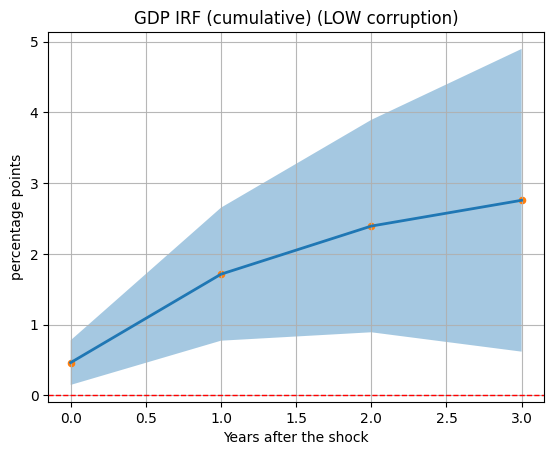

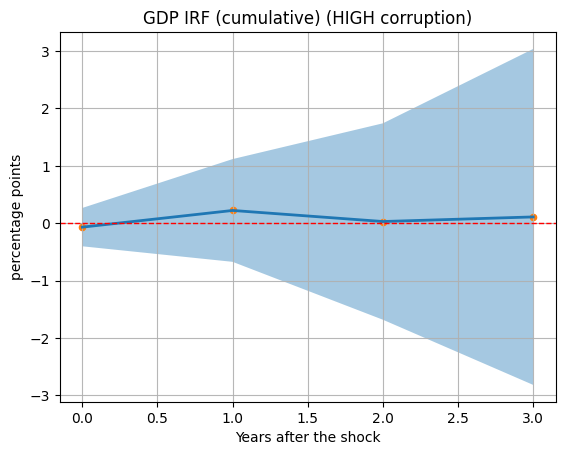

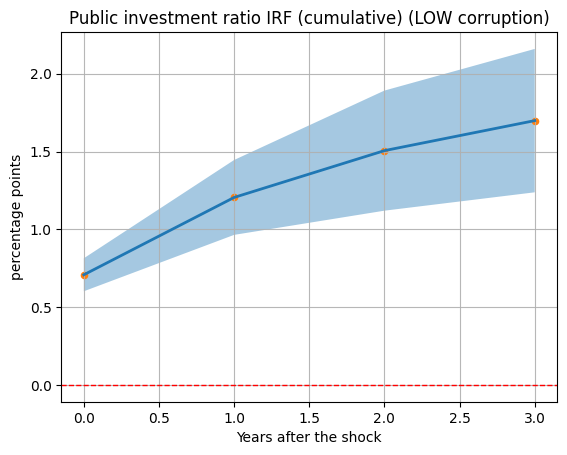

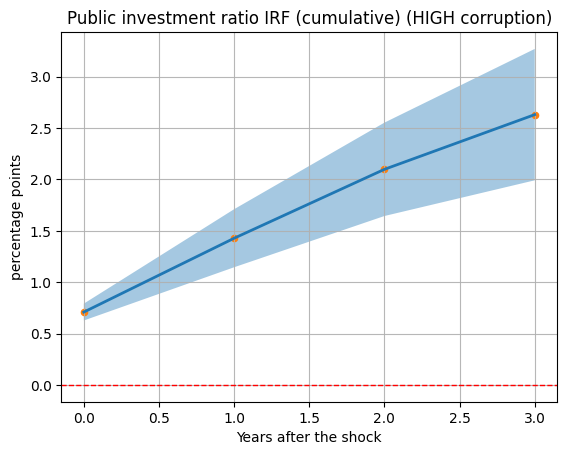

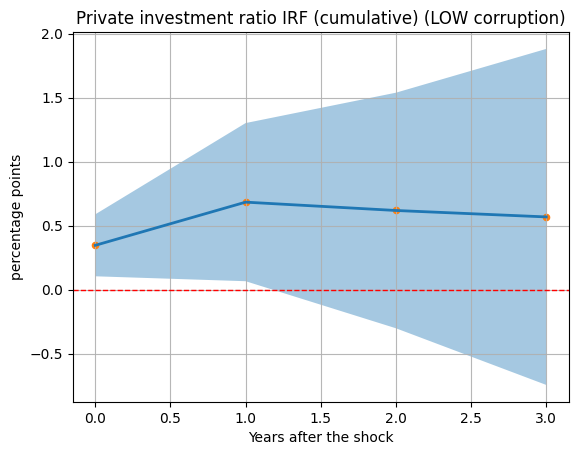

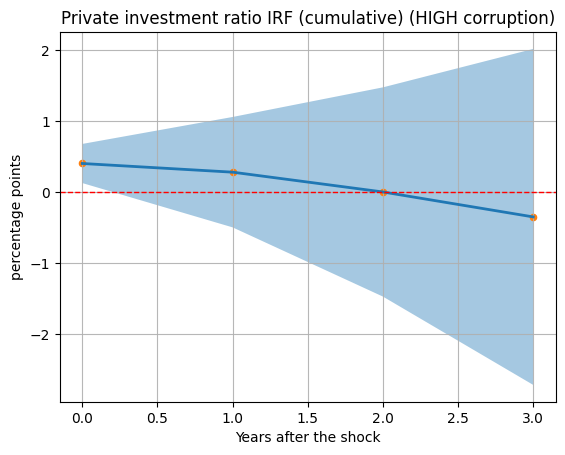

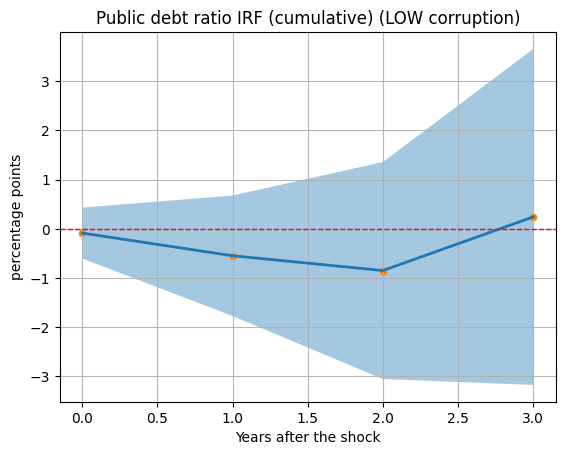

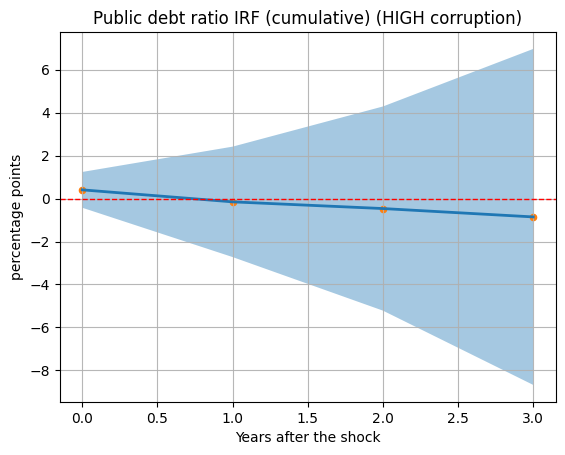

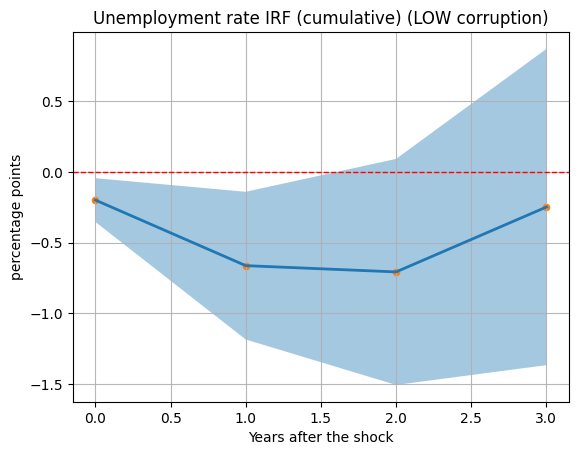

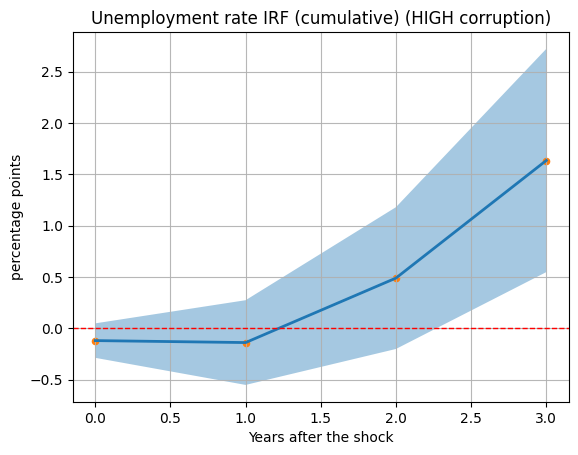

In [ ]:
# ============================================================
# CORRUZIONE (interazione) + GRAFICI LOW vs HIGH per:
#   - GDP (log_RGDP)
#   - Public investment ratio (PUBINVRATIO)
#   - Private investment ratio (INVGDP)
#   - Debt ratio (PDEBT)
#   - Unemployment rate (UNRATE)
# ============================================================
#GE_EST GOVERNMENT EFFECTIVENESS
# --- controlli baseline ---
ctrl_base = ["growth_RGDP", "PDEBT", "forecasterror", "NOMLRATE", "REER"]
DK_BW = None

def as_lp_low(res_int):
    return {
        "irf_panel_mean": res_int["irf_low_mean"],
        "irf_panel_low":  res_int["irf_low_lo"],
        "irf_panel_up":   res_int["irf_low_hi"],
    }

def as_lp_high(res_int):
    return {
        "irf_panel_mean": res_int["irf_high_mean"],
        "irf_panel_low":  res_int["irf_high_lo"],
        "irf_panel_up":   res_int["irf_high_hi"],
    }

def plot_low_high(res_int, scale=1.0, ttl="", ylab=""):
    lp_low = as_lp_low(res_int)
    lp_high = as_lp_high(res_int)
    plot_cum(lp_low,  scale=scale, ttl=f"{ttl} (LOW corruption)",  ylab=ylab)
    plot_cum(lp_high, scale=scale, ttl=f"{ttl} (HIGH corruption)", ylab=ylab)

# ============================================================
#GDP + Public investment ratio (con interazione)
# ============================================================

irf_gdp_corr = lp_lin_panel_py_interaction(
    data_set=dt,
    endog_data="log_RGDP",
    shock="forecasterror",
    corr_col="GE_EST",
    l_exog_data=ctrl_base,
    lags_exog_data=2,
    hor=3,
    entity_col="ccode",
    time_col="year_int",
    confint=1.0,
    cumul_mult=True,
    dk_bandwidth=DK_BW,
    corr_lag=1,        
    q_low=0.25,
    q_high=0.75,
    center_corr=True,
)

irf_ratio_corr = lp_lin_panel_py_interaction(
    data_set=dt,
    endog_data="PUBINVRATIO",
    shock="forecasterror",
    corr_col="GE_EST",
    l_exog_data=ctrl_base,
    lags_exog_data=2,
    hor=3,
    entity_col="ccode",
    time_col="year_int",
    confint=1.0,
    cumul_mult=True,
    dk_bandwidth=DK_BW,
    corr_lag=1,
    q_low=0.25,
    q_high=0.75,
    center_corr=True,
)


print("corr_low (centered):", irf_gdp_corr["corr_low"])
print("corr_high (centered):", irf_gdp_corr["corr_high"])

plot_low_high(irf_gdp_corr,   scale=100.0, ttl="GDP IRF (cumulative)", ylab="percentage points")
plot_low_high(irf_ratio_corr, scale=1.0,   ttl="Public investment ratio IRF (cumulative)", ylab="percentage points")

# ============================================================
#Private investment ratio (con interazione) + grafici
# ============================================================

ctrl_priv = ["growth_RGDP", "PDEBT", "forecasterror", "NOMLRATE", "INVGDP_diff", "REER"]

irf_priv_corr = lp_lin_panel_py_interaction(
    data_set=dt,
    endog_data="INVGDP",
    shock="forecasterror",
    corr_col="GE_EST",
    l_exog_data=ctrl_priv,
    lags_exog_data=2,
    hor=3,
    entity_col="ccode",
    time_col="year_int",
    confint=1.0,
    cumul_mult=True,
    dk_bandwidth=DK_BW,
    corr_lag=1,
    q_low=0.25,
    q_high=0.75,
    center_corr=True,
)

plot_low_high(irf_priv_corr, scale=1.0, ttl="Private investment ratio IRF (cumulative)", ylab="percentage points")

# ============================================================
#Debt ratio (con interazione) + grafici
# ============================================================

irf_debt_corr = lp_lin_panel_py_interaction(
    data_set=dt,
    endog_data="PDEBT",
    shock="forecasterror",
    corr_col="GE_EST",
    l_exog_data=ctrl_base,
    lags_exog_data=2,
    hor=3,
    entity_col="ccode",
    time_col="year_int",
    confint=1.0,
    cumul_mult=True,
    dk_bandwidth=DK_BW,
    corr_lag=1,
    q_low=0.25,
    q_high=0.75,
    center_corr=True,
)

plot_low_high(irf_debt_corr, scale=1.0, ttl="Public debt ratio IRF (cumulative)", ylab="percentage points")

# ============================================================
#Unemployment rate (con interazione) + grafici
# ============================================================

ctrl_unemp = ["growth_RGDP", "PDEBT", "forecasterror", "NOMLRATE", "UNRATE", "REER"]

irf_unemp_corr = lp_lin_panel_py_interaction(
    data_set=dt,
    endog_data="UNRATE",
    shock="forecasterror",
    corr_col="GE_EST",
    l_exog_data=ctrl_unemp,
    lags_exog_data=2,
    hor=3,
    entity_col="ccode",
    time_col="year_int",
    confint=1.0,
    cumul_mult=True,
    dk_bandwidth=DK_BW,
    corr_lag=1,
    q_low=0.25,
    q_high=0.75,
    center_corr=True,
)

plot_low_high(irf_unemp_corr, scale=1.0, ttl="Unemployment rate IRF (cumulative)", ylab="percentage points")


QUINDI CON IL GOVERNMENT EFFECTIVENESS SI PEGGIORA.